# Train DECiSION incl. data augmentation

## Set seeds and import packages

In [1]:
RANDOM_STATE = 42
from numpy.random import seed
seed(RANDOM_STATE)

from tensorflow import set_random_seed
set_random_seed(RANDOM_STATE)

import random
random.seed = RANDOM_STATE

import DECiSION_settings as settings

from dltoolkit.utils.generic import model_architecture_to_file, model_summary_to_file, list_images
from dltoolkit.utils.image import standardise, standardise_single, mean_subtraction
from dltoolkit.nn.segment import UNet_NN
from dltoolkit.utils.visual import plot_training_history
from dltoolkit.iomisc import HDF5Writer, HDF5Reader, HDF5Generator_Segment

from thesis_common import convert_img_to_pred, convert_pred_to_img,\
    group_images, show_image, read_preprocess_image, read_preprocess_groundtruth
from thesis_metric_loss import dice_coef, weighted_pixelwise_crossentropy_loss

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import numpy as np
import os, cv2, time, progressbar

import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Convert to HDF5

In [2]:
def create_hdf5_db(imgs_list, dn_name, img_path, img_shape, key, ext, settings, is_mask=False):
    """
    Create a HDF5 file using a list of paths to individual images to be written to the data set
    :param imgs_list: list of image paths
    :param dn_name: becomes part of the HDF5 file name
    :param img_path: path to the location of the `images` and `groundtruths` subfolders
    :param img_shape: shape of the images being written to the data set
    :param key: key to use for the data set
    :param ext: extension of the HDF5 file name
    :param settings: holds settings
    :param is_mask: True if masks are being written, False if not
    :return: the full path to the HDF5 file
    """
    # Construct the name of the database
    tmp_name = dn_name + ("_masks" if is_mask else "_imgs")
    output_path = os.path.join(os.path.dirname(img_path), tmp_name) + ext
    print(output_path)

    # Prepare the HDF5 writer, which expects a label vector. Because this is a segmentation problem just pass None
    # hdf5_writer = HDF5Writer((len(imgs_list), img_shape[0], img_shape[1], img_shape[2]), output_path,
    hdf5_writer = HDF5Writer(((len(imgs_list),) + img_shape),
                             output_path=output_path,
                             feat_key=key,
                             label_key=None,
                             del_existing=True,
                             buf_size=len(imgs_list),
                             dtype_feat=np.float32 if not is_mask else np.uint8
                             )

    classcounts = [0] * settings.NUM_CLASSES

    # Loop through all images
    widgets = ["Creating HDF5 database ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(imgs_list), widgets=widgets).start()
    for i, img in enumerate(imgs_list):
        image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

        # Apply binary thresholding to ground truth masks
        if is_mask:
            _, image = cv2.threshold(image, settings.MASK_BINARY_THRESHOLD, settings.MASK_BLOODVESSEL, cv2.THRESH_BINARY)

            # Convert to the format produced by the model
            # print(image.shape)
            # print(np.array([image]).shape)
            # image = convert_img_to_pred(np.array([image]), settings, settings.VERBOSE)

            for ix, cl in enumerate([settings.MASK_BACKGROUND, settings.MASK_BLOODVESSEL]):
                classcounts[ix] += len(np.where(image == cl)[0])
        else:
            # Apply preprocessing to images (not to ground truth masks)
            # print("before, min {} max {}".format(np.min(image), np.max(image)))
            # print("Max prior: {}".format(np.max(image)))
            # image = standardise_single(image)
            # image = mean_subtraction(image)
            # print("Max after: {}".format(np.max(image)))
            # print(" after, min {} max {}".format(np.min(image), np.max(image)))
            pass

        # Reshape from (height, width) to (height, width, 1)
        image = image.reshape((img_shape[0], img_shape[1], img_shape[2]))

        if not is_mask:
        #     image = standardise_single(image)
#             image = mean_subtraction(image)
            image=image/255.

        hdf5_writer.add([image], None)
        pbar.update(i)

    if is_mask:
        total = sum(classcounts)
        for i in range(settings.NUM_CLASSES):
            classcounts[i] = int(total / classcounts[i])

    pbar.finish()
    hdf5_writer.close()

    if is_mask:
        return output_path#, classcounts
    else:
        return output_path


def perform_hdf5_conversion(settings):
    # Prepare the path to the training images and ground truths
    img_exts = ".jpg"
    img_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_IMAGES)
    msk_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_GROUND_TRUTH)
    test_path = os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES)

    # Create a list of paths to the individual patient folders
    patient_fld_imgs = sorted([os.path.join(img_path, e.name) for e in os.scandir(img_path) if e.is_dir()])
    patient_fld_masks = sorted([os.path.join(msk_path, e.name) for e in os.scandir(msk_path) if e.is_dir()])
    test_imgs = sorted(list(list_images(basePath=test_path, validExts=img_exts)))

    # Obtain a list of paths to the training images and ground truths for each patient
    img_list = []
    msk_list = []
    for patient_ix, (p_fld_imgs, p_fld_masks) in enumerate(zip(patient_fld_imgs, patient_fld_masks)):
        img_list.extend(sorted(list(list_images(basePath=p_fld_imgs,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])
        msk_list.extend(sorted(list(list_images(basePath=p_fld_masks,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])

    assert(len(img_list) == len(msk_list))

    # Split the training set into a training and validation set
    train_img, val_img, train_msk, val_msk = train_test_split(img_list, msk_list,
                                                              test_size=settings.TRN_TRAIN_VAL_SPLIT,
                                                              random_state=settings.RANDOM_STATE,
                                                              shuffle=True)

    print("Check train data: {} = {}".format(train_img[0], train_msk[0]))
    print("  Check val data: {} = {}".format(val_img[0], val_msk[0]))
    print("Num train: {}, num val: {}".format(len(train_img), len(val_img)))

    # Create the HDF5 data sets
    output_paths = []

    # Training images
    output_paths.append(create_hdf5_db(train_img, "train", img_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    # Training ground truths
    output_paths.append(create_hdf5_db(train_msk, "train", msk_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings,
                                       is_mask=True))

    # Validation images
    output_paths.append(create_hdf5_db(val_img, "val", img_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    # Validation ground truths
    output_paths.append(create_hdf5_db(val_msk, "val", msk_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings,
                                       is_mask=True))

    # Test images (no ground truths available, no need to split)
    output_paths.append(create_hdf5_db(test_imgs, "test", test_path,
                                        (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                        key=settings.HDF5_KEY, ext=settings.HDF5_EXT,
                                        settings=settings))

    return output_paths

In [3]:
# Convert image files to HDF5
if settings.IS_DEVELOPMENT:
    print("\n--- Converting images to HDF5")
    hdf5_paths = perform_hdf5_conversion(settings)
else:
    # During development avoid performing HDF5 conversion for every run
    hdf5_paths = ["../data/MSC8002/training/train_imgs.h5",
                  "../data/MSC8002/training/train_masks.h5",
                  "../data/MSC8002/training/val_imgs.h5",
                  "../data/MSC8002/training/val_masks.h5"
                  "../data/MSC8002/test/test_imgs.h5"
                  ]

Creating HDF5 database  94% |################################   | ETA:  0:00:00


--- Converting images to HDF5
Check train data: ../data/MSC8002/training/images/patient_1/S572080075.jpg = ../data/MSC8002/training/groundtruths/patient_1/S57208Filter0075.jpg
  Check val data: ../data/MSC8002/training/images/patient_1/S572080010.jpg = ../data/MSC8002/training/groundtruths/patient_1/S57208Filter0010.jpg
Num train: 85, num val: 10
../data/MSC8002/training/train_imgs.h5


Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database N/A% |                                  | ETA:  --:--:--

../data/MSC8002/training/train_masks.h5
../data/MSC8002/training/val_imgs.h5


Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database  43% |###############                    | ETA:  0:00:00

../data/MSC8002/training/val_masks.h5
../data/MSC8002/test/test_imgs.h5


Creating HDF5 database 100% |###################################| Time: 0:00:00


In [ ]:
# Test reading batches of images
data_gen_args = dict(rotation_range=2.,
                     width_shift_range=0.01,
                     height_shift_range=0.01,
                     shear_range=1.2,
                     zoom_range=0.01,
                     fill_mode='nearest')

rdr = HDF5Generator_Segment(hdf5_paths[0], hdf5_paths[1],
                            batch_size=4, num_classes=settings.NUM_CLASSES,
                            data_gen_args=data_gen_args,
                            feat_key=settings.HDF5_KEY)
# lala = rdr.generator(converter=convert_img_to_pred, settings=settings, num_epochs=1)
lala = rdr.generator(converter=None, settings=settings, num_epochs=1)

for ix, (imgs, grt) in enumerate(lala):
    print("imgs {}, grt: {}".format(imgs.shape, grt.shape))
    group_images(imgs[0:9], 3, 0.0, False, "../output/test_grp_images"+str(ix))
    group_images(grt[0:9], 3, 1.0, False, "../output/test_grp_grts"+str(ix))

## Class distribution

In [4]:
# Print class distribution
class_weights = [settings.CLASS_WEIGHT_BACKGROUND, settings.CLASS_WEIGHT_BLOODVESSEL]
print("Class distribution: {}".format(class_weights))

Class distribution: [1.0, 10.0]


## Create U-Net model

In [5]:
# Instantiate the U-Net model
unet = UNet_NN(img_height=settings.IMG_HEIGHT,
               img_width=settings.IMG_WIDTH,
               img_channels=settings.IMG_CHANNELS,
               num_classes=settings.NUM_CLASSES)

# model = unet.build_model_sigmoid()
# model = unet.build_model_flatten()
model = unet.build_model_softmax()

## Create paths

In [6]:
# Prepare some path strings
model_path = os.path.join(settings.MODEL_PATH, "DECiSION_" + unet.title + "_ep{}.model".format(settings.TRN_NUM_EPOCH))
summ_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title + "_model_summary.txt")
csv_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title + "_training_ep{}_bs{}.csv".format(settings.TRN_NUM_EPOCH,
                                                                                            settings.TRN_BATCH_SIZE))

## Save/print model architecture information

In [7]:
# Print the architecture to the console, a text file and an image
model.summary()
model_summary_to_file(model, summ_path)
model_architecture_to_file(unet.model, settings.OUTPUT_PATH + "DECiSION_" + unet.title)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 160, 160, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Compile the model

In [8]:
# Prepare callbacks
callbacks = [ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1),
             EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=settings.TRN_EARLY_PATIENCE,
                           verbose=0,
                           mode="auto"),
             CSVLogger(csv_path, append=False),
             ]

# Set the optimiser, loss function and metrics
# opt = Adam()
# metrics = [dice_coef]
# loss = "binary_crossentropy"
opt = Adam()
metrics = [dice_coef]
loss = weighted_pixelwise_crossentropy_loss(class_weights)

# Compile and fit
model.compile(optimizer=opt, loss=loss, metrics=metrics)

## Fit the model

In [9]:
# Prepare generators
start_time = time.time()

# Training set generator using data augmentation
rdr_train = HDF5Generator_Segment(hdf5_paths[0], hdf5_paths[1],
                                  batch_size=settings.TRN_BATCH_SIZE,
                                  num_classes=settings.NUM_CLASSES,
#                                   data_gen_args=data_gen_args,
                                  feat_key=settings.HDF5_KEY)
gen_train = rdr_train.generator(converter=convert_img_to_pred, settings=settings,
                                num_epochs=settings.TRN_NUM_EPOCH)

# Validation set generator (does NOT use data augmentation)
rdr_val = HDF5Generator_Segment(hdf5_paths[2], hdf5_paths[3],
                                batch_size=settings.TRN_BATCH_SIZE,
                                num_classes=settings.NUM_CLASSES,
                                feat_key=settings.HDF5_KEY)
gen_val = rdr_val.generator(converter=convert_img_to_pred, settings=settings,
                                num_epochs=settings.TRN_NUM_EPOCH)

print(" num trn samples: {}".format(rdr_train.num_images()))
print(" num val samples: {}".format(rdr_val.num_images()))

print(" steps_per_epoch: {}".format(rdr_train.num_images()/settings.TRN_BATCH_SIZE))
print("validation_steps: {}".format(rdr_val.num_images()/settings.TRN_BATCH_SIZE))

# Fit the model
hist = model.fit_generator(gen_train,
                 epochs=settings.TRN_NUM_EPOCH,
#                  epochs=1,
                 steps_per_epoch=rdr_train.num_images()/settings.TRN_BATCH_SIZE,
                 verbose=2,
                 validation_data=gen_val,
                 validation_steps=rdr_val.num_images()/settings.TRN_BATCH_SIZE,
                 shuffle=True,
                 callbacks=callbacks)

print("Elapsed training time: {} min".format(int((time.time() - start_time))/60))

 num trn samples: 85
 num val samples: 10
 steps_per_epoch: 85.0
validation_steps: 10.0
Epoch 1/1
 - 124s - loss: 18510.6031 - dice_coef: 0.9191 - val_loss: 3645.6946 - val_dice_coef: 0.9891

Epoch 00001: val_loss improved from inf to 3645.69456, saving model to ../savedmodels/DECiSION_UNet_brain_softmax_ep100.model
Elapsed training time: 2.1 min


## Plot the results

In [10]:
plot_training_history(hist,
                      settings.TRN_NUM_EPOCH,
                      show=False,
                      save_path=settings.OUTPUT_PATH + unet.title,
                      time_stamp=True,
                      metric="dice_coef")

## Perform pipeline test

Loading image HDF5: ../data/MSC8002/training/train_imgs.h5 with dtype = float32

Loading ground truth HDF5: ../data/MSC8002/training/train_masks.h5 with dtype = uint8



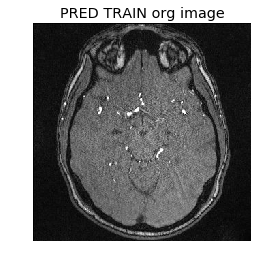

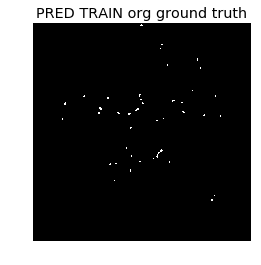

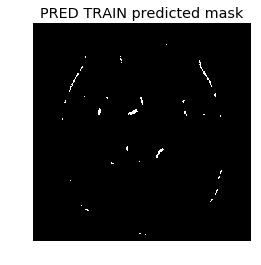

  original 1.0 dtype float32
  gr truth 255 dtype uint8
prediction 255 dtype uint8


In [12]:
# Read images and ground truths
train_imgs = read_preprocess_image(hdf5_paths[0], settings.HDF5_KEY)
train_grndtr = read_preprocess_groundtruth(hdf5_paths[1], settings.HDF5_KEY)

# For pipeline testing only, predict on one training image
predictions = model.predict(train_imgs[[59]], batch_size=settings.TRN_BATCH_SIZE, verbose=2)

# predictions = predictions
# predictions = convert_pred_to_img_flatten(predictions, settings.TRN_PRED_THRESHOLD)
predictions = convert_pred_to_img(predictions, settings, settings.TRN_PRED_THRESHOLD)


show_image(np.squeeze(train_imgs[0]), 'PRED TRAIN org image')
show_image(np.squeeze(train_grndtr[0]), 'PRED TRAIN org ground truth')
show_image(np.squeeze(predictions[0]), 'PRED TRAIN predicted mask')

print("  original {} dtype {}".format(np.max(train_imgs[0]), train_imgs[0].dtype))
print("  gr truth {} dtype {}".format(np.max(train_grndtr[0]), train_grndtr[0].dtype))
print("prediction {} dtype {}".format(np.max(predictions[0]), predictions[0].dtype))